In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt
import copy
import feather
import re

import matplotlib.pyplot as plt
import statsmodels.stats.stattools

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [11]:
def plot_posterior_predictive(ppc, 
                              observations,
                              fun1 = lambda x: np.mean(x, axis = 1), 
                              fun2 = lambda x: np.mean(x),
                              xlab = "mean(x)",
                             title = "Posterior predictive of mean"):
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist(fun1(ppc['obs']), bins=20, alpha=0.5)
    ax.axvline(fun2(observations))
    ax.set(title=title, xlabel=xlab, ylabel='Frequency');

# PBMC 68k

In [32]:
def get_logfcs_comparison(df, type1, type2):
    type2 = re.sub("[ \+\\/]", ".", type2)
    return(np.array(df[df.cluster == type1]["logFC." + type2]))

In [33]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc68k_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc_68k_normal_logfcs.feather')

In [34]:
class1 = "Naive CD8+"
class2 = "Naive CD4+"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

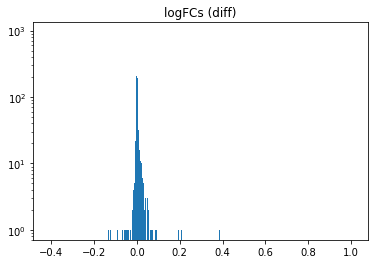

In [35]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

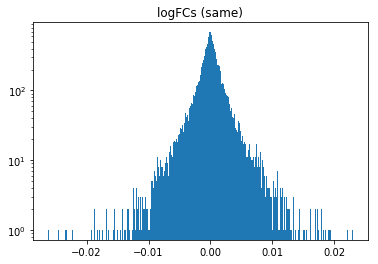

In [36]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

In [59]:
def run_model(observations, nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
        sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)

        sd = pm.Gamma('sd', alpha = 1., beta = 1.)

        # Sample from Gaussian for null
        pm.Normal('null',
                 mu = mu_null,
                 sd = sd_null,
                 observed = nulls)

        null_component = pm.Normal.dist(mu = mu_null,
                                      sd = sd_null)
        

        #pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
        #neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)
        pos_component = pm.Deterministic('pos_component', tt.abs_(pm.Normal('pos_x', mu = mu_pos, sd = sd)))
        neg_component = pm.Deterministic('neg_component', tt.abs_(pm.Normal('neg_x', mu = mu_neg, sd = sd)))

        pm.Mixture('obs',
                  w = tt.as_tensor([(1-de_prob), de_prob * (1-down_prob), de_prob * down_prob]),
                  comp_dists = [null_component, pos_component, neg_component],
                  observed = observations)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=2000, model=model)
    
    return({'trace': trace, 'ppc': ppc})


In [80]:
with pm.Model() as model:
    x = pm.Normal('hi', mu=2., sd=1.)
    y = pm.Deterministic('hi2', x + 2)
    z = pm.Normal.dist(mu=2., sd=1.)

print(type(x))
print(type(y))
print(type(z))

print(x.distribution)
print(y.distribution)

<class 'pymc3.model.FreeRV'>
<class 'theano.tensor.var.TensorVariable'>
<class 'pymc3.distributions.continuous.Normal'>


AttributeError: 'TensorVariable' object has no attribute 'distribution'

In [60]:
pbmc_res = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(pbmc_res['trace'])

IndexError: axis 1 is out of bounds [-1, 1)

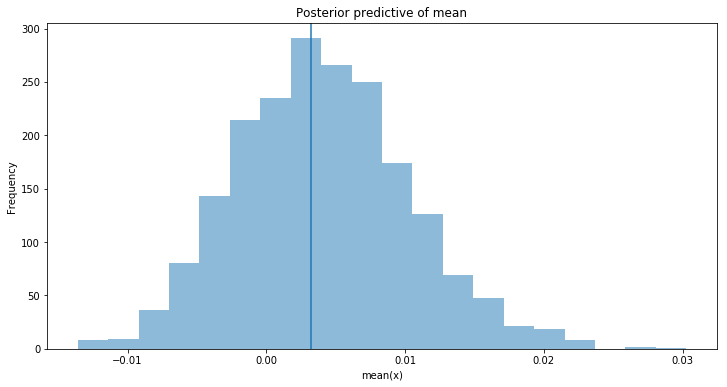

In [12]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

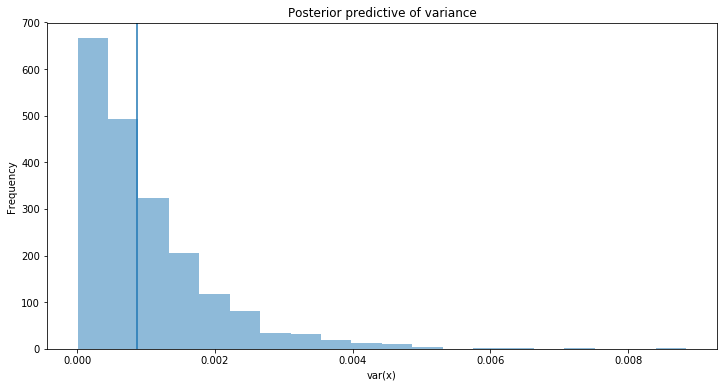

In [13]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

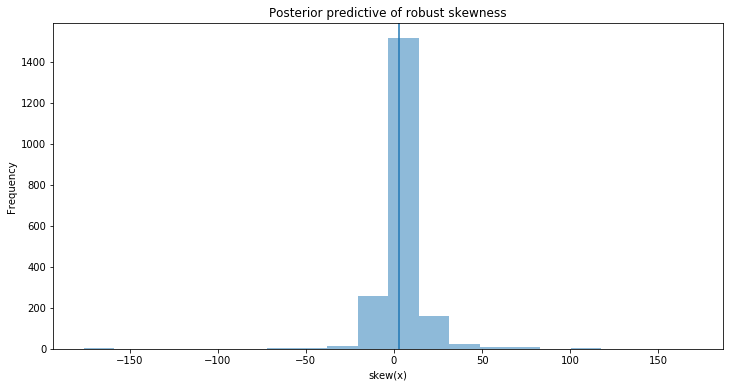

In [14]:
plot_posterior_predictive(pbmc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")

These posterior predictive checks provide support that our model parameters approximately recapitulate the input data. 

# HGSC high confidence

We'll perform the same analysis, but on the HGSC data that has been generated locally.

In [17]:
sce_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/hgsc_markers.feather')
sce_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/hgsc_normal_logfcs.feather')

## CD4+ vs. CD8+ T cells

In [18]:
class1 = "CD4 T cells"
class2 = "Cytotoxic T cells"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

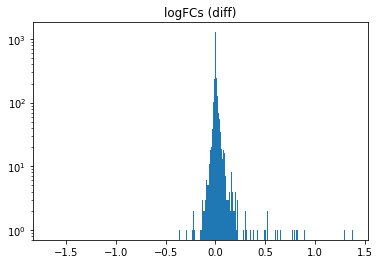

In [19]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

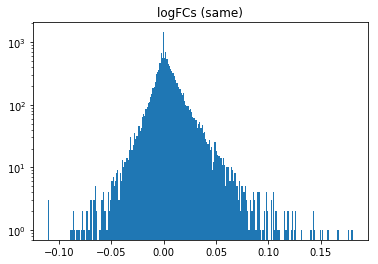

In [20]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:20<00:00, 96.94it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f973a1d2a58>,
      dtype=object)

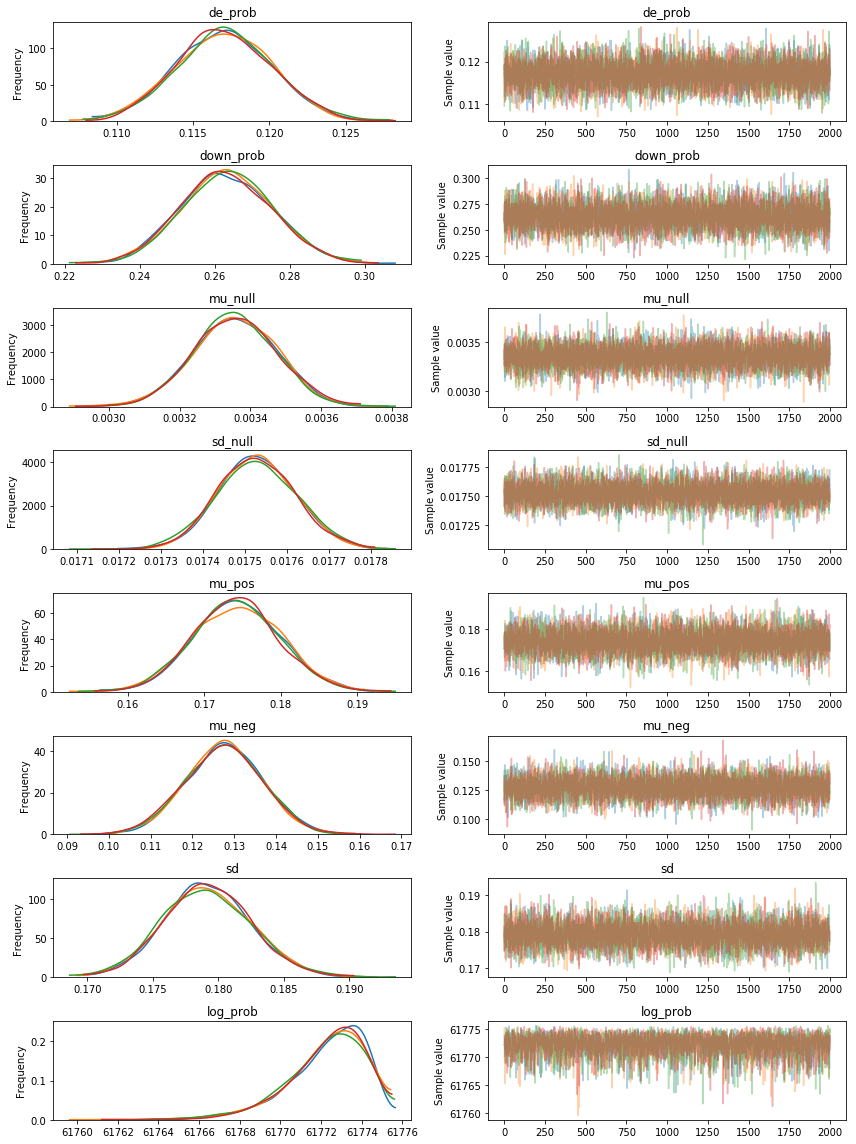

In [21]:
hgsc_res = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(hgsc_res['trace'])

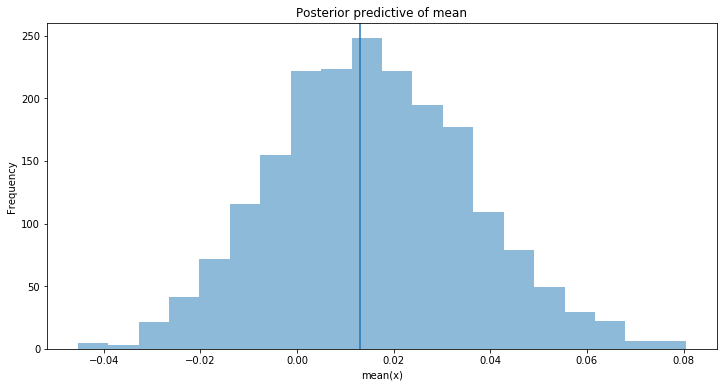

In [22]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.mean(x, axis = 1), 
                          fun2 = lambda x: np.mean(x), 
                          xlab = "mean(x)",
                          title = "Posterior predictive of mean")

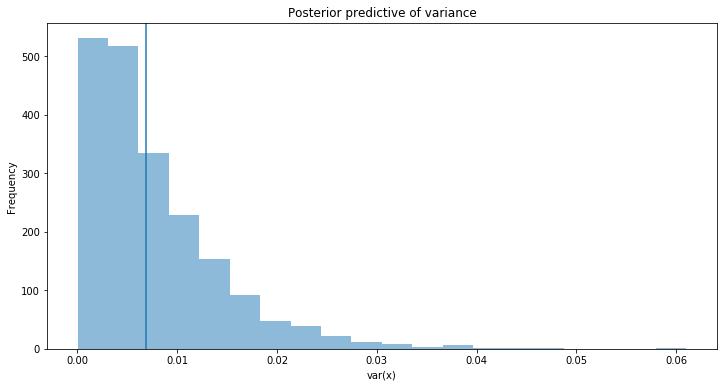

In [23]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: np.var(x, axis = 1), 
                          fun2 = lambda x: np.var(x), 
                          xlab = "var(x)",
                          title = "Posterior predictive of variance")

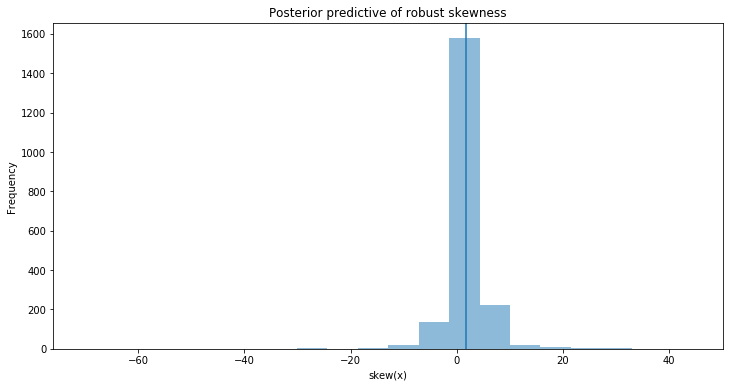

In [24]:
plot_posterior_predictive(hgsc_res['ppc'], 
                          logfcs_diff,
                          fun1 = lambda x: statsmodels.stats.stattools.robust_skewness(x, axis = 1)[3], 
                          fun2 = lambda x: statsmodels.stats.stattools.robust_skewness(x)[3], 
                          xlab = "skew(x)",
                          title = "Posterior predictive of robust skewness")

Note that the $\mu_{pos}$ and $\mu_{neg}$ values are higher in this comparison than in the PBMC dataset. This could be due to a few reasons:

* Naive CD4+ and CD8+ T cells differ less than CD4+ and CD8+ T cells
* The 90\% probability threshold set for CellAssign predictions in the HGSC dataset filters out cells that may be assigned with less certainty to CD4+ or CD8+

## Cancer cells vs. fibroblasts

Cancer cells and fibroblasts should be fairly phenotypically distinct -- we can use this comparison as an example of the other end of the spectrum for these parameters.

In [26]:
class1 = "Fibroblast/Myofibroblast"
class2 = "Cancer cell"

logfcs_diff = get_logfcs_comparison(sce_markers, class1, class2)
logfcs_same = np.array(sce_null_logfcs[(sce_null_logfcs['celltype'] == class2) & (sce_null_logfcs['permutation'] == 1)].logfc)

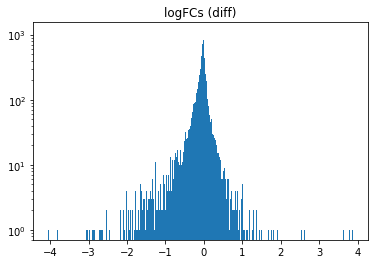

In [29]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
plt.yscale('log', nonposy='clip')
plt.show()

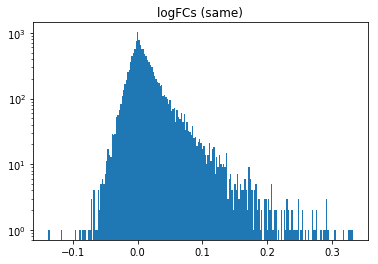

In [30]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
plt.yscale('log', nonposy='clip')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu_neg, mu_pos, sd_null, mu_null, down_prob, de_prob]
100%|██████████| 2000/2000 [00:20<00:00, 96.54it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96fcea1d68>,
      dtype=object)

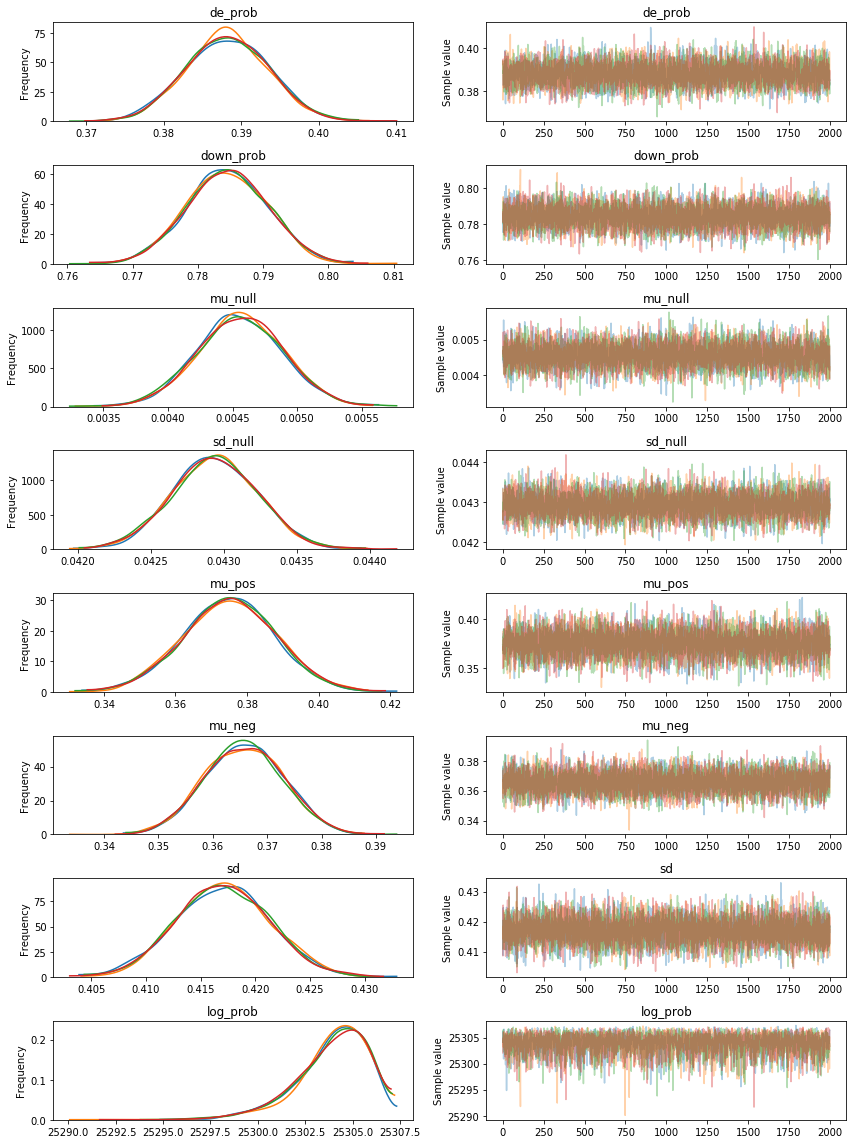

In [31]:
hgsc_res2 = run_model(logfcs_diff, logfcs_same, iter_count=2000, tune_iters = 2000)

pm.plots.traceplot(hgsc_res2['trace'])

As is clear, `de_prob`, $\mu_{pos}$, and $\mu_{neg}$ are higher due to the greater difference between fibroblasts and cancer cells. 